<a href="https://colab.research.google.com/github/Rahul711sharma/Credit-Card-Default-/blob/main/Credit_Card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objective**

* ## To predict the chances of Credit Card Default made by the Client.


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

##Importing Libraries

In [185]:
!pip install lime
!pip install shap

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.4MB 65kB/s 
     |████████████████████████████████| 204kB 20.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=3a88cecdea82400dc00c1116b520db8f5fdaa1e02ce5aececf32944a7e85c755
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [ ]:
import pyspark
import pyspark.sql as sql

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotly.express as pe
import sklearn.metrics as met
import shap
import lime
%matplotlib inline

In [ ]:
sc = pyspark.SparkContext()

In [ ]:
sqlContext = pyspark.SQLContext(sc)

## Importing Data

In [ ]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls")
df.head(3)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [ ]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls",header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
sql_df = sqlContext.createDataFrame(df)

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
sql_df.select('*').limit(10).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Describe Data

In [ ]:
sql_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- LIMIT_BAL: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- EDUCATION: long (nullable = true)
 |-- MARRIAGE: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PAY_0: long (nullable = true)
 |-- PAY_2: long (nullable = true)
 |-- PAY_3: long (nullable = true)
 |-- PAY_4: long (nullable = true)
 |-- PAY_5: long (nullable = true)
 |-- PAY_6: long (nullable = true)
 |-- BILL_AMT1: long (nullable = true)
 |-- BILL_AMT2: long (nullable = true)
 |-- BILL_AMT3: long (nullable = true)
 |-- BILL_AMT4: long (nullable = true)
 |-- BILL_AMT5: long (nullable = true)
 |-- BILL_AMT6: long (nullable = true)
 |-- PAY_AMT1: long (nullable = true)
 |-- PAY_AMT2: long (nullable = true)
 |-- PAY_AMT3: long (nullable = true)
 |-- PAY_AMT4: long (nullable = true)
 |-- PAY_AMT5: long (nullable = true)
 |-- PAY_AMT6: long (nullable = true)
 |-- default payment next month: long (nullable = true)



In [ ]:
sql_df.summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|            PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|        BILL_AMT4|         BILL_AMT5|        BILL_AMT6|          PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+-

In [ ]:
type(sql_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
sql_df.toPandas().shape

(30000, 25)

##Null Values In data

In [ ]:
sql_df.filter(sql_df.SEX.isNull()).count()

0

In [ ]:
sql_df.toPandas().isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

##Exploratory Data 

### Categorical Data Exploration

In [ ]:
sql_df.createOrReplaceTempView('data')

In [ ]:
sql_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [ ]:
spark.sql(f"select SEX,count(*) as Count from data group by SEX").show()

+---+-----+
|SEX|Count|
+---+-----+
|  1|11888|
|  2|18112|
+---+-----+



In [57]:
# Function to find distinct Values

def distinct_values(data):
  for i in data.columns:
    #distinct values with less than 30 unique values
    if len(set(list(data[i])))<30:
      print(f"{i} Distinct Values :  \n {data[i].value_counts()} \n")

In [58]:
distinct_values(sql_df.toPandas())

SEX Distinct Values :  
 2    18112
1    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       3

In [59]:
# Core Categorical Data
Cat_data = ['SEX','EDUCATION','MARRIAGE','default payment next month']

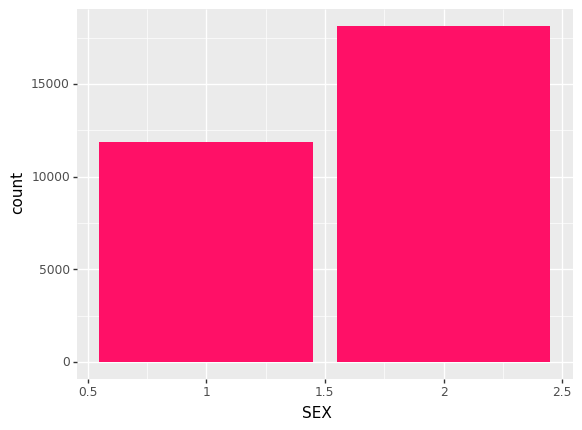

<ggplot: (8787712511817)>


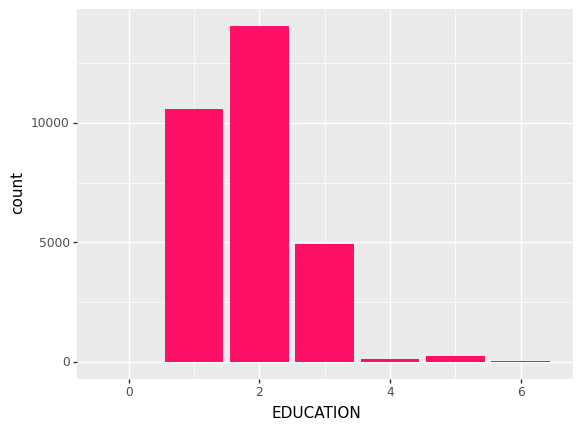

<ggplot: (8787713604793)>


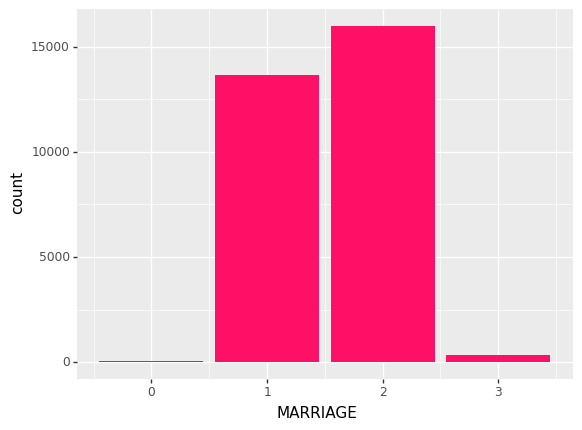

<ggplot: (8787713684329)>


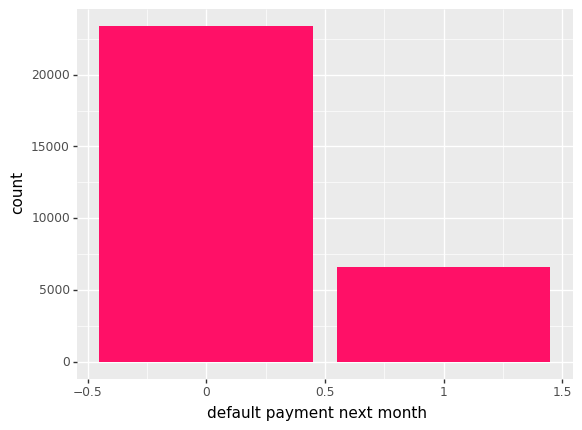

<ggplot: (8787710383501)>


In [60]:
# Bar graphs
for i in Cat_data:
  print(ggplot(sql_df.toPandas())+aes(i,color=i)+geom_bar(fill = "#FF1067"))


**Treatment of classes with close to 0 observations. We either remove them or add them to nearest majority class.**

In [61]:
df2 = sql_df.toPandas()

In [62]:
df2['MARRIAGE']=df2['MARRIAGE'].replace({3:1,2:1,1:0})

In [63]:
df2['EDUCATION'] = df2['EDUCATION'].replace({1:0,2:1,3:2,4:2,5:2,6:2})
df2['EDUCATION'].value_counts()

1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64

In [64]:
df2['SEX']= df2['SEX'].replace({2:1,1:0})
df2['SEX'].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

In [65]:
distinct_values(df2)

SEX Distinct Values :  
 1    18112
0    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 1    16287
0    13713
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 8        2
 1        2
Name: PAY_4, dtype: int64 



* We can see that our dependent variable has a majority class. We need to pick model and algorithms complying to that in future.

###**Bivariate analysis**

####**Education by Gender**

In [66]:
Education_by_gender = pd.pivot_table(df2,index='EDUCATION',columns='SEX',aggfunc={'SEX':'count'})
Education_by_gender

SEX      
SEX           0     1
EDUCATION            
0          4362  6237
1          5374  8656
2          2152  3219

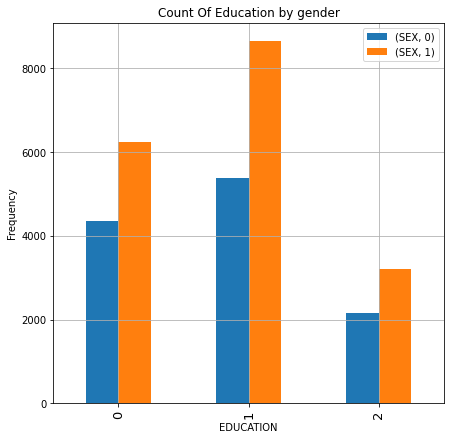

In [67]:
Education_by_gender.plot(kind='bar',figsize=(7,7),grid=1)
plt.title("Count Of Education by gender")
plt.ylabel('Frequency')
plt.legend()

* We can see in the above chart that people with University level education are highest in numbers.

####**People who defaulted groups in diffrent categories**


In [68]:
# Default by education
Default_by_education = pd.DataFrame(pd.pivot_table(df2,index='EDUCATION',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_education

default payment next month      
default payment next month                          0     1
EDUCATION                                                  
0                                                8563  2036
1                                               10700  3330
2                                                4101  1270

Text(0.5, 1.0, 'Count of People who defaulted by education')

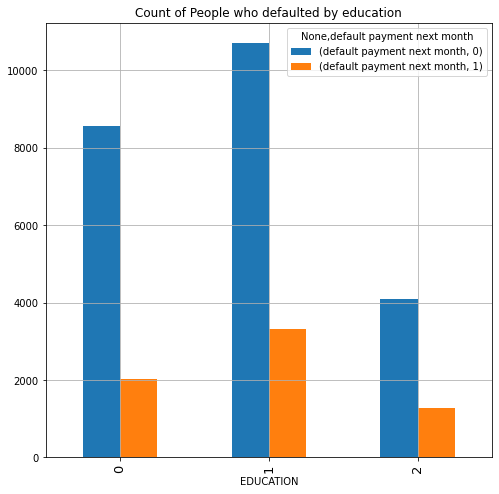

In [69]:
Default_by_education.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8),grid=1)

plt.title('Count of People who defaulted by education')

In [70]:
# Default by gender
Default_by_gender = pd.DataFrame(pd.pivot_table(df2,index='SEX',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_gender

default payment next month      
default payment next month                          0     1
SEX                                                        
0                                                9015  2873
1                                               14349  3763

Text(0.5, 1.0, 'Count of People who defaulted by gender')

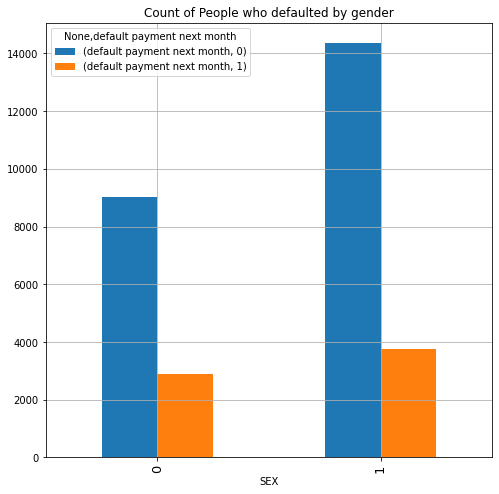

In [71]:
Default_by_gender.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8),grid=1)

plt.title('Count of People who defaulted by gender')

####**Treatment of Past payments due columns**

In [72]:
payments = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for i in payments:
  df2[i] = df2[i].replace({8:3,7:3,6:3,5:3,4:3})
  df2[i]= np.array(df2[i])+2
  print(df2[i].value_counts())

2    14737
1     5686
3     3688
0     2759
4     2667
5      463
Name: PAY_0, dtype: int64
2    15730
1     6050
4     3927
0     3782
5      483
3       28
Name: PAY_2, dtype: int64
2    15764
1     5938
0     4085
4     3819
5      390
3        4
Name: PAY_3, dtype: int64
2    16455
1     5687
0     4348
4     3159
5      349
3        2
Name: PAY_4, dtype: int64
2    16947
1     5539
0     4546
4     2626
5      342
Name: PAY_5, dtype: int64
2    16286
1     5740
0     4895
4     2766
5      313
Name: PAY_6, dtype: int64


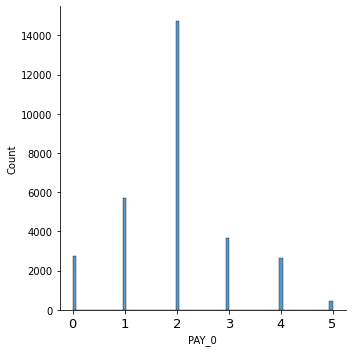

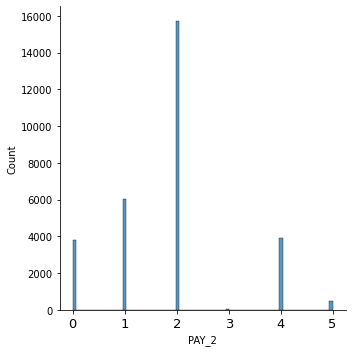

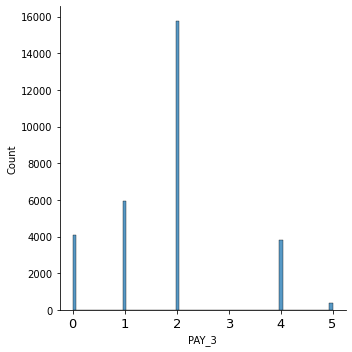

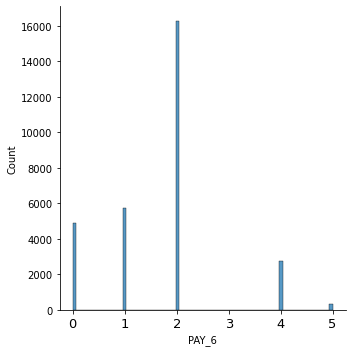

In [74]:
sns.displot(df2['PAY_0'],kde=0)
sns.displot(df2['PAY_2'],kde=0)
sns.displot(df2['PAY_3'],kde=0)
sns.displot(df2['PAY_6'],kde=0)


###**`AGE` Distribution**

In [ ]:
from scipy.stats import mode
mode_age = int(mode(df2['AGE'])[0])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



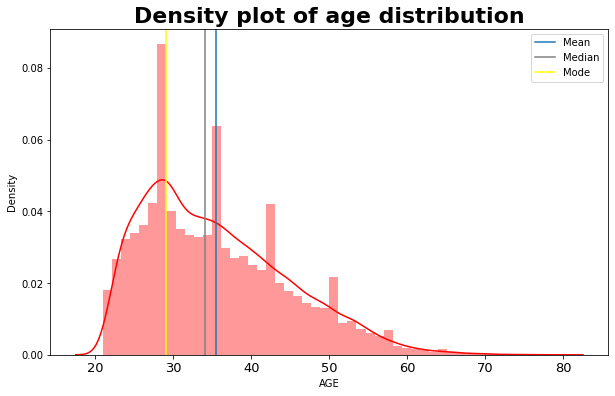

In [ ]:
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=13) 
sns.distplot(df2['AGE'],color='red')
plt.title('Density plot of age distribution',{'size':22,'weight':'bold'})
plt.axvline(np.mean(df2['AGE']),label='Mean')
plt.axvline(np.median(df2['AGE']),color='grey',label='Median')
plt.axvline(mode_age,color='yellow',label='Mode')
plt.legend()

* We can see that it is a skewed distribution.



* Even after trying square root transformation and log transformation it didn't come close to normal distribution

### `Limit Balance` Histogram Graph

In [80]:
pe.histogram(df2, x=(df2["LIMIT_BAL"]),marginal="box",facet_col='default payment next month',title='Limit Balance Histogram based on defaults payments',histnorm='probability density')

###**Correlation Plot**

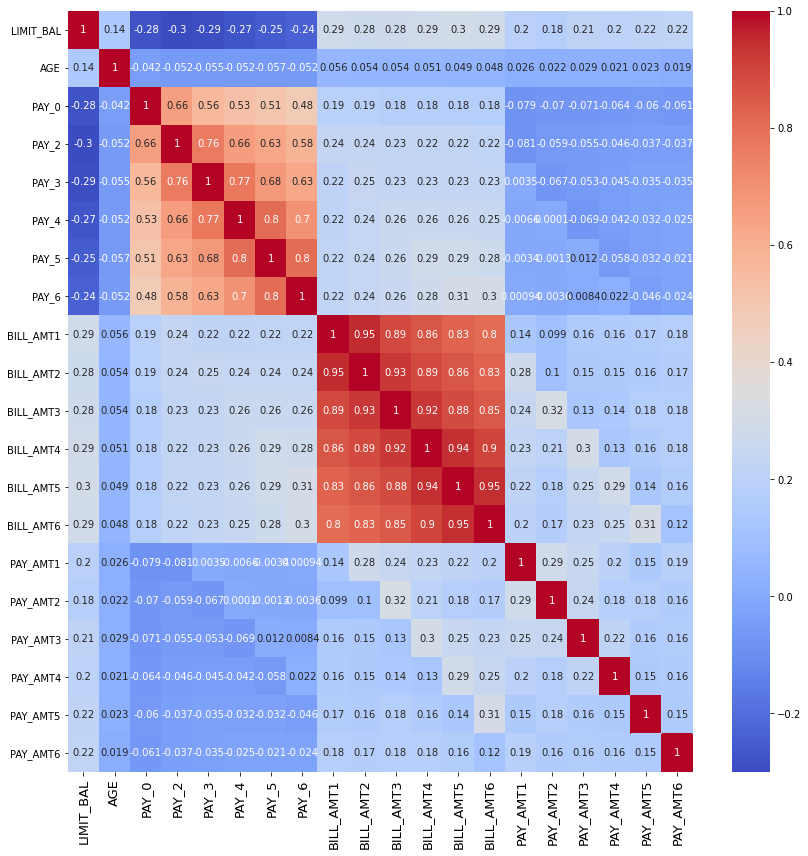

In [88]:
plt.figure(figsize=(14,14))
sns.heatmap(df2[[x for x in df2.columns if x not in Cat_data+['ID']]].corr(),annot=True,cmap="coolwarm")

* Bill Amount variables are highly correlated.

##Train test split 

In [89]:
df2 = df2.iloc[:,1:]
df2.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,1,1,0,24,4,4,1,1,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,1,1,1,26,1,4,2,2,2,4,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,1,1,34,2,2,2,2,2,2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,1,0,37,2,2,2,2,2,2,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,1,0,57,1,2,1,2,2,2,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [105]:
x = df2.drop(['default payment next month','BILL_AMT3',	'BILL_AMT4',	'BILL_AMT5',	'BILL_AMT6'	],axis='columns')
y = df2['default payment next month']
print(f"{x.shape}\n {y.shape}")

(30000, 19)
 (30000,)


In [106]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22500, 19)
(22500,)
(7500, 19)
(7500,)


###Logistic Regression Model

In [107]:
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression

In [108]:
logit = LogisticRegression(max_iter=100000)

In [109]:
logit.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
accuracy_score(y_train,logit.predict(x_train))

0.7772

In [111]:
#Accuracy Score
accuracy_score(y_test,logit.predict(x_test))

0.7826666666666666

In [ ]:
# Classification Report
print(met.classification_report(y_test,logit.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5873
           1       0.00      0.00      0.00      1627

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.69      7500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier

In [112]:
dt= DecisionTreeClassifier(class_weight="balanced")
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [113]:
accuracy_score(y_test,dt.predict(x_test))

0.7366666666666667

In [114]:
print(met.classification_report(y_test,dt.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      5873
           1       0.39      0.39      0.39      1627

    accuracy                           0.74      7500
   macro avg       0.61      0.61      0.61      7500
weighted avg       0.74      0.74      0.74      7500



In [119]:
def feature_importances(model,train_data):
  df=pd.DataFrame({'Features':train_data.columns, 'scores': model.feature_importances_}).sort_values('scores',ascending=0)
  plt.figure(figsize=(8,8))
  sns.barplot(df['scores'],df['Features'])
  plt.title(f"Feature Importance Graph")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



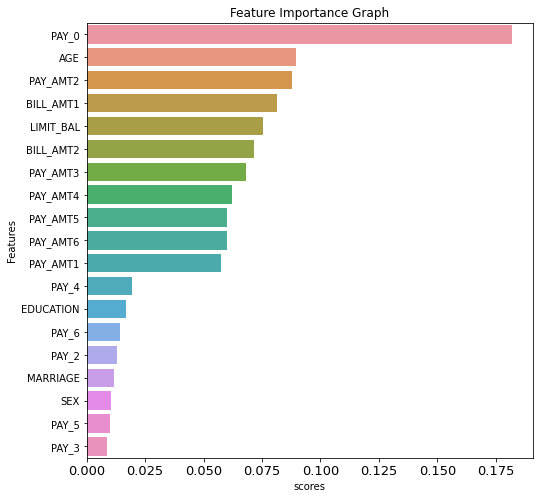

In [120]:
feature_importances(dt,x_train)

##Gradient Boosting Classifier

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

In [116]:
gboost = GradientBoostingClassifier()
gboost.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [117]:
accuracy_score(y_train,gboost.predict(x_train))

0.826

In [118]:
accuracy_score(y_test,gboost.predict(x_test))

0.8208

In [172]:
from sklearn.model_selection import GridSearchCV

#number of trees
n_estimators = [100,120]

#Maximum depth of tree
max_depth = [6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}


In [ ]:
gboost2= GradientBoostingClassifier()
gb_grid =GridSearchCV(estimator=gboost2, param_grid = param_dict,cv = 5, verbose=2)
gb_grid.fit(x_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.5s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.4s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.2s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  15.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  18.3s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  18.3s
[CV] max_depth=6, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 25.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [ ]:
accuracy_score(y_train,gb_grid.predict(x_train))

0.8477333333333333

In [ ]:
accuracy_score(y_test,gb_grid.predict(x_test))

0.8198666666666666

In [122]:
print(met.classification_report(y_test,gboost.predict(x_test)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5873
           1       0.66      0.36      0.46      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



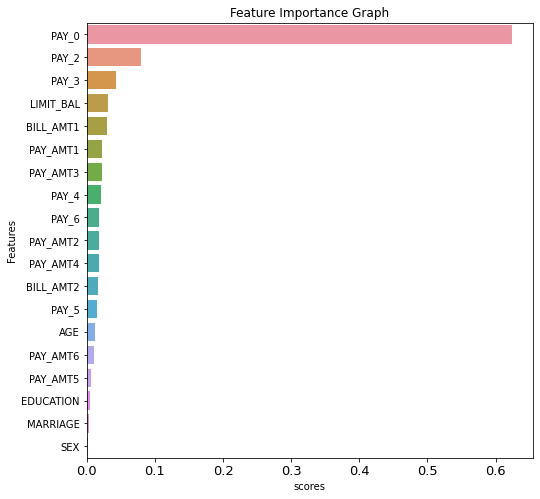

In [124]:
feature_importances(gboost,x_train)

###XGBOOST ALGORITHM

In [159]:
import xgboost

In [160]:
xgb = xgboost.XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [161]:
accuracy_score(y_train,xgb.predict(x_train))

0.8253777777777778

In [167]:
#result on test data
print(met.classification_report(y_test,xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5873
           1       0.66      0.35      0.46      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.67      7500
weighted avg       0.80      0.82      0.80      7500



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



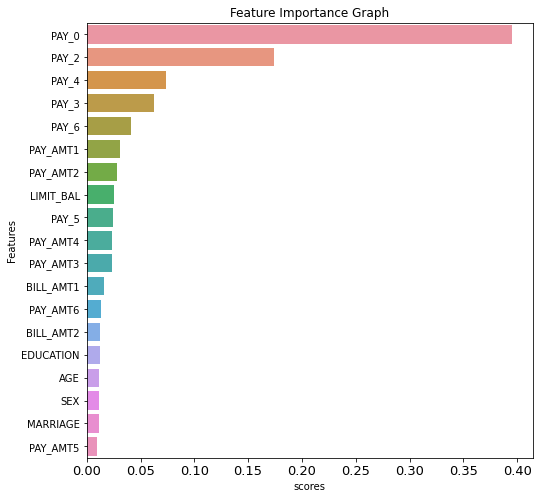

In [186]:
feature_importances(xgb,x_train)

###Random Forest Classifier

In [162]:
from sklearn.ensemble import RandomForestClassifier

In [168]:
rfc =RandomForestClassifier()


In [173]:
rf_grid =GridSearchCV(estimator=rfc, param_grid = param_dict,cv = 5, verbose=2)
rf_grid.fit(x_train,y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.7s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.7s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.7s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.7s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.7s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=   2.0s
[CV] max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=   2.0s
[CV] max_depth=6, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [204]:
rf = RandomForestClassifier(max_depth= 8,
 min_samples_leaf= 50,
 min_samples_split= 100,
 n_estimators= 120)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [176]:
rf_grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 120}

In [177]:
accuracy_score(y_train,rf_grid.predict(x_train))

0.8241333333333334

In [179]:
print(met.classification_report(y_train,rf_grid.predict(x_train)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     17491
           1       0.70      0.37      0.49      5009

    accuracy                           0.82     22500
   macro avg       0.77      0.66      0.69     22500
weighted avg       0.81      0.82      0.80     22500



###ROC-AUC

In [194]:
from sklearn.metrics import roc_curve
#roc Scores on test data

#roc curve for logistic regression
fpr_log,tpr_log,thresh_log =roc_curve(y_test,logit.predict_proba(x_test)[:,1],pos_label=1)

#roc curve for decision tree

fpr_dt,tpr_dt,thresh_dt =roc_curve(y_test,dt.predict_proba(x_test)[:,1],pos_label=1)

#roc curve for random Forest

fpr_gb,tpr_gb,thresh_gb =roc_curve(y_test,gboost.predict_proba(x_test)[:,1],pos_label=1)

# roc curve for gredient boost 

fpr_xgb,tpr_xgb,thresh_xgb =roc_curve(y_test,xgb.predict_proba(x_test)[:,1],pos_label=1)


fpr_rf,tpr_rf,thresh_rf =roc_curve(y_test,rf_grid.predict_proba(x_test)[:,1],pos_label=1)


# roc curve for fpr=tpr

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

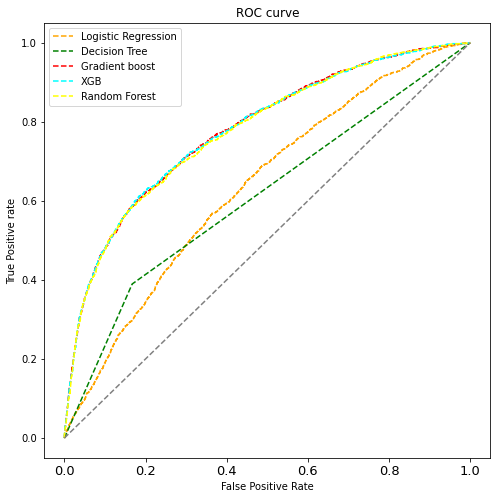

In [197]:
plt.figure(figsize=(8,8))
plt.plot(fpr_log, tpr_log, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, linestyle='--',color='green', label='Decision Tree')
plt.plot(fpr_gb, tpr_gb, linestyle='--',color='red', label='Gradient boost')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='cyan', label='XGB')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='yellow', label='Random Forest')

plt.plot(p_fpr, p_tpr, linestyle='--', color='grey')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()

### Model Interpretation

In [212]:
explainer = shap.Explainer(xgb,x_train)
shap_value = explainer(x_train)

 96%|=================== | 21696/22500 [00:25<00:00]       

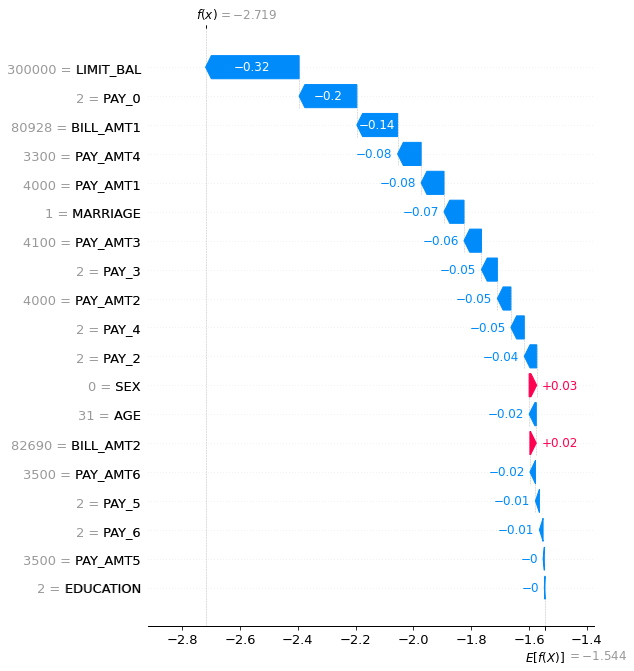

In [213]:
shap.plots.waterfall(shap_value[0],max_display=50)

Waterfall plots are designed to display explanations for individual predictions.

The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

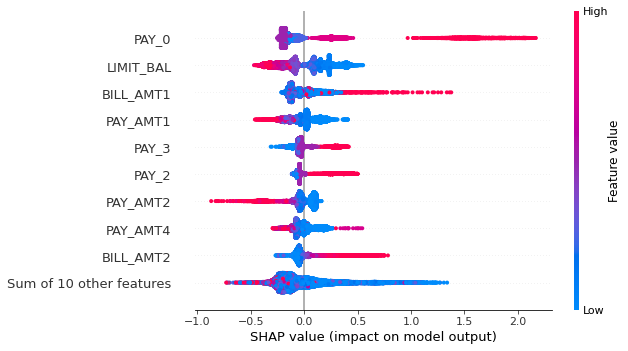

In [214]:
shap.plots.beeswarm(shap_value)

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output.

The x position of the dot is determined by the SHAP value (shap_values.value[instance,feature]) of that feature, and dots “pile up” along each feature row to show density.

Color is used to display the original value of a feature (shap_values.data[instance,feature]).

In the plot above we can see that **PAY_0** is the most important feature on average.

In [215]:
shap.initjs()
shap.plots.force(shap_value[0])

features pushing the prediction higher are shown in **red**, those pushing the prediction lower are in **blue**.

**Interpretation with LIME Library**

In [216]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.astype(int).values,  
mode='classification',training_labels=y_train,feature_names=x_train.columns)

In [217]:
x_train.iloc[1]

LIMIT_BAL    20000
SEX              0
EDUCATION        1
MARRIAGE         1
AGE             24
PAY_0            2
PAY_2            2
PAY_3            2
PAY_4            2
PAY_5            2
PAY_6            2
BILL_AMT1    15730
BILL_AMT2    16776
PAY_AMT1      1313
PAY_AMT2      2110
PAY_AMT3      4000
PAY_AMT4      6000
PAY_AMT5      4000
PAY_AMT6       174
Name: 23942, dtype: int64

In [219]:
exp= lime_explainer.explain_instance(x_train.iloc[1],predict_fn=rf.predict_proba)

In [220]:
exp.show_in_notebook(show_table=1)

* The model is 85% confident this this person is not going to default.

###**Conclusion**

* Data categorical variables had minority classes which were added to their closest majority class
* People who studied the higher University education defaulted the most.
* People who had an University level education were most in the numbers.
* There were not huge gap but female clients tended to default the most.
* Labels of the data were imbalanced and had a significant difference.
* Logistic regression Accuracy were 78% on test data. It over-fitted with 1% with respect to train accuracy.
* Random Forest gave best recall results.
* Gradient boost gave the highest accuracy of 82% on test dataset.
* Repayment in the month of september i.e ``pay_0`` tended to be the most important feature for our machine learning model.
